<a href="https://colab.research.google.com/github/dgsmith1988/Arpeggiator/blob/master/ECSE_551_miniproject_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Run this to select Python 3.6 as per the assignment requirements
# TODO: Figure out how to automate this...
!sudo update-alternatives --config python3

# Check the result
!python3 --version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
  0            /usr/bin/python3.7   2         auto mode
* 1            /usr/bin/python3.6   1         manual mode
  2            /usr/bin/python3.7   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1
Python 3.6.9


In [2]:

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

#!ls /content/drive/MyDrive/ECSE-551_Miniproject_1/

red_wine_df_data = pd.read_csv('/content/drive/MyDrive/ECSE-551_Miniproject_1/red_wine.csv', names=["fixed acidity", "volatile acidity", "citric acid", "residual sugars", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "high quality"], header=None)
diabetes_df_data = pd.read_csv('/content/drive/MyDrive/ECSE-551_Miniproject_1/diabetes.csv', names=["# pregnancies", "BMI", "insulin level", "age", "predictor 5", "predictor 6", "predictor 7", "predictor 8", "diabetes"], header=None)

Mounted at /content/drive


In [4]:
red_wine_df_data.head()
red_wine_df_data.dtypes


fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugars         float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
high quality              int64
dtype: object

In [ ]:
diabetes_df_data.head()

,# pregnancies,BMI,insulin level,age,predictor 5,predictor 6,predictor 7,predictor 8,diabetes
0,0.35294,0.74372,0.59016,0.35354,0.00000,0.50075,0.234420,0.483330,1
1,0.47059,0.91960,0.52459,0.00000,0.00000,0.34724,0.253630,0.183330,1
2,0.00000,0.68844,0.32787,0.35354,0.19858,0.64232,0.943640,0.200000,1
3,0.17647,0.39196,0.40984,0.32323,0.10402,0.46200,0.072588,0.083333,1
4,0.11765,0.98995,0.57377,0.45455,0.64184,0.45455,0.034159,0.533330,1


In [6]:
#Class definitions
class LogisticRegressionBaseClass:
    """Abstract parent class which ML models will adhere to in order to facilitate comparisons, all the sub-classses
    should implement their own versions of fit and predict"""
    weights = []
    learning_rate = 1.0
    stopping_threshold = 1.0
    max_iterations = 1000
    initial_weights = []
    initial_learning_rate = 1.0

    def __init__(self, initial_weights=[], initial_learning_rate=.90, stopping_threshold=.0001, max_iterations=1000):
        self.initial_learning_rate = initial_learning_rate
        self.initial_weights = initial_weights
        self.stopping_threshold = stopping_threshold
        self.max_iterations = max_iterations
        self.reset()

    def calculate_cross_entropy_loss(self, X, y):
        # This function assumes that X already has had the bias column added to handle w0
        #diff = y - self.sigmoid(np.matmul(X, self.weights.T))
        #diff = diff.iloc[:, 0]
        # Todo: there's probably a slicker linear algebra approach to this computation which could leverage the
        #  vectorized computation methods
        cross_entropy_loss = np.zeros([1, len(X.columns)])
        for i in range(len(X)):
            cross_entropy_loss += X.iloc[i, :] * (y[i] - self.sigmoid(np.matmul(X.iloc[i, :], self.weights.T)))
        return -cross_entropy_loss

    def fit(self, X, y):
        """Method used to train the ML model
        X = training data
        y = label vectors corresponding to training data
        can be overridden to support hyper parameters"""
        def plot(iteration, x1_range=[-10, 10], x2_range=[-10, 10], num_db_points=50):
            """Helper function to plot the current data to aid in debugging
            This only works in two dimensions"""
            decision_boundary = np.zeros([num_db_points, 2])
            decision_boundary[:, 0] = np.linspace(x1_range[0], x1_range[1], num_db_points)
            # this formula only works in two-dimensions as i've explicitly solved for the second feature (x2 or y)
            b = -self.weights[0, 0] / self.weights[0, 2]
            m = -self.weights[0, 1] / self.weights[0, 2]
            decision_boundary[:, 1] = b + m*decision_boundary[:, 0]
            fig, ax = plt.subplots()
            ax.scatter(X.iloc[y[y == 0].index.values, 1], X.iloc[y[y == 0].index.values, 2], c='r')
            ax.scatter(X.iloc[y[y == 1].index.values, 1], X.iloc[y[y == 1].index.values, 2], c='b')
            ax.plot(decision_boundary[:, 0], decision_boundary[:, 1])
            ax.grid()
            ax.set_xlim(x1_range)
            ax.set_ylim(x2_range)
            ax.set_title('Decision Boundary - Iteration #%i' % iteration)
            print('iteration #%i' % iteration)
            print('m = %f' % m)
            print('b = %f\n' % b)
            plt.show()

        # add in the implicit x0 = 1 so the bias weight gets properly taken into account
        X.insert(0, 'Bias', np.ones([len(X), 1]))
        plot(-1)
        learning_rate = self.initial_learning_rate

        for k in range(self.max_iterations):
            gradient = self.calculate_cross_entropy_loss(X, y)
            new_weights = self.weights - learning_rate*gradient
            difference_squared = pow(np.linalg.norm(self.weights - new_weights), 2)
            if difference_squared < self.stopping_threshold:
                break
            self.weights = new_weights
            plot(k)

    def predict(self, unlabeled_data):
        """Method used to predict labels for the specified input data
        returns a list of the predicted values. This method assumes the test_data
        comes in the format where the rows are training samples and columns are the different
        features"""

        # add in the implicit x0 = 1 so the bias weight gets properly taken into account
        unlabeled_data.insert(0, 'Bias', np.ones([len(unlabeled_data), 1]))

        # as we are assuming a linear model for the log-odds ratio, we can compute the log-odds
        # for each training sample as Ax = b where are is the training data, x are the weights
        # and b is the log-odds ratio (each element of B is a dot-product of the weights with
        # the training sample's values)
        log_odds = np.matmul(unlabeled_data, self.weights)

        # plug this into the sigmoid function to get P(y=1|x)
        probability_class_1 = self.sigmoid(log_odds)
        probability_class_0 = 1 - self.sigmoid(log_odds)

        # given that True/False are functionally equivalent to 1/0 then this statement will
        # classify the points for us based which probability is higher
        predicted_labels = probability_class_1 > probability_class_0
        return predicted_labels

    def reset(self):
        # clear the weights for things like iterating between folds
        self.weights = self.initial_weights
        self.learning_rate = self.initial_learning_rate

    @staticmethod
    def sigmoid(a):
        return 1/(1 + np.exp(-a))


def Accu_eval(predicted_labels, true_labels) -> float:
    correct_predictions = (predicted_labels == true_labels).sum()
    accuracy = correct_predictions / len(predicted_labels)
    return accuracy


class K_Fold_Cross_Validation:
    folds = []
    ml_model = []
    data = []

    def __init__(self, ml_model, data, folds=10):
        self.ml_model = ml_model
        self.data = data
        self.folds = folds

    @staticmethod
    def calculate_fold_sizes(num_folds, num_samples):
        # helper function which calculates the fold sizes to be as balanced
        # as possible (no fold has > 1 sample than another) to handle the
        # scenario where the number of samples doesn't cleanly divide by the
        # fold count
        #
        # returns a list with the size of the fold in each element for easier looping
        fold_size_1 = num_samples // num_folds
        fold_size_2 = fold_size_1 + 1

        num_folds_size_2 = num_samples - num_folds * fold_size_1
        num_folds_size_1 = num_folds - num_folds_size_2

        return num_folds_size_1 * [fold_size_1] + num_folds_size_2 * [fold_size_2]

    def cross_validate(self) -> float:
        fold_errors = np.zeros(self.folds)
        fold_sizes = self.calculate_fold_sizes(self.folds, len(self.data))

        indices = np.random.permutation(len(self.data))
        # indices = np.arange(len(dataFrame))

        fold_start = 0
        fold_end = fold_start + fold_sizes[0]
        for i in range(self.folds):
            # train and validate the data here
            validation_data = self.data.iloc[indices[fold_start:fold_end]]
            training_data = self.data.iloc[np.setxor1d(indices[fold_start:fold_end], indices, True)]
            # debugging statements
            #print(i)
            #print(validation_data)
            #print(training_data)
            #print('\n\n')

            # clear the model so the old training doesn't influence this fold
            self.ml_model.reset()
            self.ml_model.fit(training_data.iloc[:, :-1], training_data.iloc[:, -1])
            predicted_labels = self.ml_model.predict(validation_data.iloc[:, :-1])
            true_labels = validation_data.iloc[:, -1]
            fold_errors[i] = 1 - Accu_eval(predicted_labels, true_labels)

            if i != self.folds - 1:
                fold_start = fold_end
                fold_end = fold_start + fold_sizes[i + 1]
        return np.average(fold_errors)


In [18]:
#Test functions
def test_Accu_eval():
    predicted_labels = pd.Series(5*[True] + 5*[False], name="label")
    true_labels = pd.Series(5*[True] + 5*[False], name="label")
    if Accu_eval(predicted_labels, true_labels) != 1:
        print("test_Accu_eval() - Fail test 1")

    predicted_labels = pd.Series(10*[True] + 0*[False], name="label")
    true_labels = pd.Series(5*[True] + 5*[False], name="label")
    if Accu_eval(predicted_labels, true_labels) != .5:
        print("test_Accu_eval() - Fail test 2")

    predicted_labels = pd.Series(10 * [True] + 0 * [False], name="label")
    true_labels = pd.Series(0*[True] + 10*[False], name="label")
    if Accu_eval(predicted_labels, true_labels) != 0:
        print("test_Accu_eval() - Fail test 3")


def test_calculate_fold_sizes():
    # test the corner cases regarding even division first
    fold_count = 5
    sample_count = 10
    fold_sizes = K_Fold_Cross_Validation.calculate_fold_sizes(fold_count, sample_count)
    if sum(fold_sizes) != sample_count:
        print("test_calculate_fold_sizes() - Fail test 1")

    sample_count = 13
    fold_sizes = K_Fold_Cross_Validation.calculate_fold_sizes(fold_count, sample_count)
    if sum(fold_sizes) != sample_count:
        print("test_calculate_fold_sizes() - Fail test 2")

    sample_count = 9
    fold_sizes = K_Fold_Cross_Validation.calculate_fold_sizes(fold_count, sample_count)
    if sum(fold_sizes) != sample_count:
        print("test_calculate_fold_sizes() - Fail test 3")

    # test the cases from the actual data
    fold_count = 10
    sample_count = 1599
    fold_sizes = K_Fold_Cross_Validation.calculate_fold_sizes(fold_count, sample_count)
    if sum(fold_sizes) != sample_count:
        print("test_calculate_fold_sizes() - Fail test 4")

    sample_count = 600
    fold_sizes = K_Fold_Cross_Validation.calculate_fold_sizes(fold_count, sample_count)
    if sum(fold_sizes) != sample_count:
        print("test_calculate_fold_sizes() - Fail test 5")


def test_K_Fold_Cross_Validation():
    # there are corresponding print statements in the validate() method which should be uncommented first
    num_folds = 5
    fake_data = {
        'a': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11],
        'b': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 11],
        'label': [True, False, True, False, True, False, True, False, True, False, True],
    }

    # fake_data = {
    #     'a': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #     'b': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    #     'label': [True, False, True, False, True, False, True, False, True, False],
    # }

    # fake_data = {
    #     'a': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    #     'b': [10, 11, 12, 13, 14, 15, 16, 17, 18],
    #     'label': [True, False, True, False, True, False, True, False, True],
    # }

    data_frame = pd.DataFrame(fake_data)
    dummy_ml_model = ML_Model_Dummy([])

    k_fold_cross_validation = K_Fold_Cross_Validation(dummy_ml_model, data_frame, num_folds)
    model_error_average = k_fold_cross_validation.cross_validate()
    print("Model error average %", 100*model_error_average)
  

def test_sigmoid():
    a = np.linspace(-10, 10, 100)
    y = LogisticRegressionBaseClass.sigmoid(a)

    plt.plot(a, y)
    plt.xlabel("a")
    plt.ylabel("sigmoid(x)")

    plt.show()


def test_predict():
    # keep the weights to a simple summation for easier testing purposes
    lr_model = LogisticRegressionBaseClass([0, 1, 1, 1], 1)

    # make it so the first sample has p1 > p0, second sample has p1 == p0, and third sample has p1 < p0
    unlabeled_data_matrix = np.eye(3)
    unlabeled_data_matrix[0, :] = [1, 1, 1]
    unlabeled_data_matrix[1, :] = [1, -1, 0]
    unlabeled_data_matrix[2, :] = [-1, -1, -1]

    predicted_labels = lr_model.predict(pd.DataFrame(unlabeled_data_matrix))
    # print(type(predicted_labels))
    if predicted_labels.equals(pd.Series([True, False, False])):
        print("test_predict() has passed")
    else:
        print("test_predict() has failed")


def test_cross_entropy_loss():
    lr_model = LogisticRegressionBaseClass(np.array([0, 1, 1, 1], ndmin=2))

    # make it so the first sample has p1 > p0, second sample has p1 == p0, and third sample has p1 < p0
    # ones in the first column are for the bias
    X = np.zeros([3, 4])
    X[0, :] = [1, 2, 2, 2]
    X[1, :] = [1, -2, -2, -2]
    X[2, :] = [1, 0, 0, 0]

    y = [1, 0, 1]
    cross_entropy_loss = lr_model.calculate_cross_entropy_loss(pd.DataFrame(X), pd.Series(y))
    # this one is a hard one to test so use this as a way to manually step through
    # the function under more controlled conditions
    print('Cross entropy loss = ', cross_entropy_loss)


def test_fit():
    num_points_per_cluster = 5

    # first cluster of points
    x1_min = 0
    x1_max = 10
    x2_min = 3
    x2_max = 5
    x1_values = (x1_max - x1_min) * np.random.random([num_points_per_cluster, 1]) + x1_min
    x2_values = (x2_max - x2_min) * np.random.random([num_points_per_cluster, 1]) + x2_min
    cluster_0 = np.concatenate((x1_values, x2_values), 1)

    # second cluster of points
    x1_min = 0
    x1_max = 10
    x2_min = 0
    x2_max = 1.5
    x1_values = (x1_max - x1_min) * np.random.random([num_points_per_cluster, 1]) + x1_min
    x2_values = (x2_max - x2_min) * np.random.random([num_points_per_cluster, 1]) + x2_min
    cluster_1 = np.concatenate((x1_values, x2_values), 1)

    # create a pandas series corresponding to the different labels of the data points
    y = pd.Series(len(cluster_0) * [0] + len(cluster_1) * [1], name='label')
    X = pd.DataFrame(np.concatenate((cluster_0, cluster_1), 0))

    # m = 0
    # b = 2
    # w2 = 1
    m = 1
    b = 0
    w2 = 1
    weights = np.array([-b*w2, -m*w2, w2], ndmin=2)
    lr_model = LogisticRegressionBaseClass(weights)
    lr_model.fit(X, y)

Python 3.6.9
iteration #-1
m = 1.000000
b = 0.000000



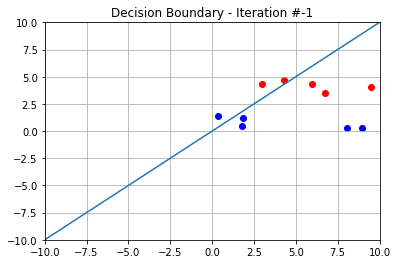

iteration #0
m = 3.100855
b = 0.527193



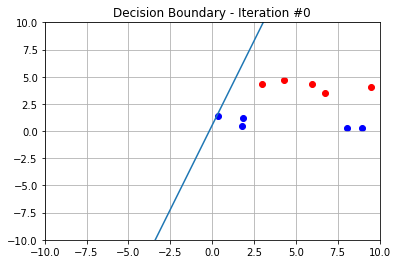

iteration #1
m = -0.692169
b = -0.107718



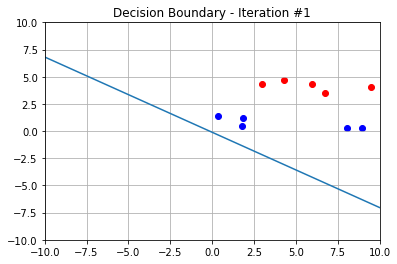

iteration #2
m = 0.190777
b = 0.112318



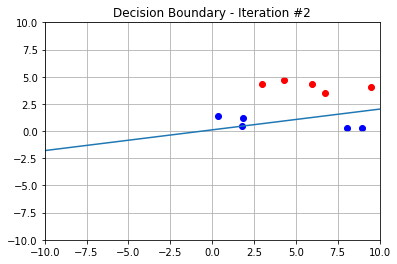

iteration #3
m = 0.381525
b = 0.262375



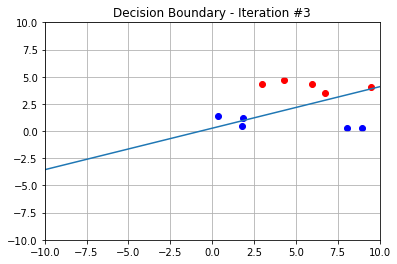

iteration #4
m = 0.539521
b = 0.422264



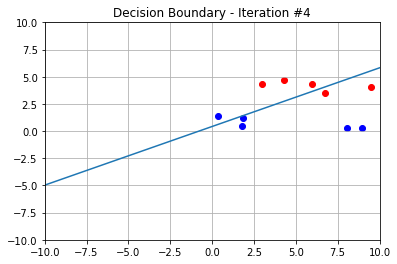

iteration #5
m = -0.328297
b = 0.262242



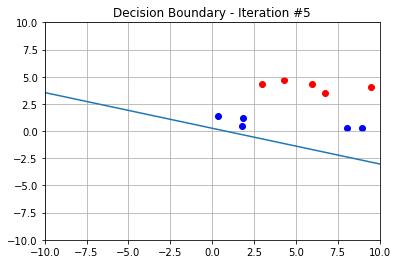

iteration #6
m = 0.750850
b = 0.585476



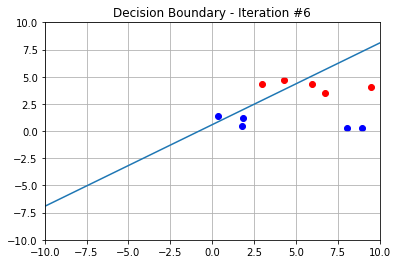

iteration #7
m = -0.278681
b = 0.303729



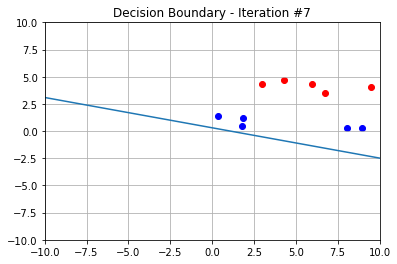

iteration #8
m = 0.513390
b = 0.544743



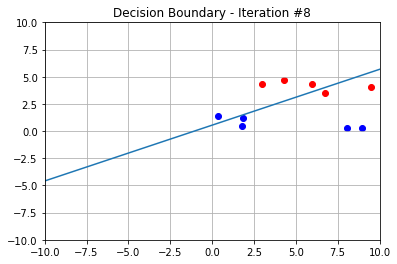

iteration #9
m = -0.092260
b = 0.406485



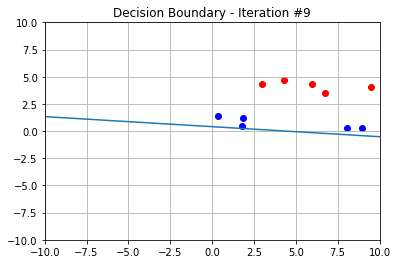

iteration #10
m = 0.650482
b = 0.638291



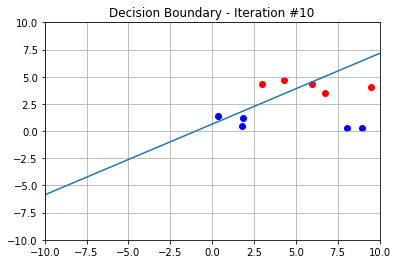

iteration #11
m = -0.096546
b = 0.412159



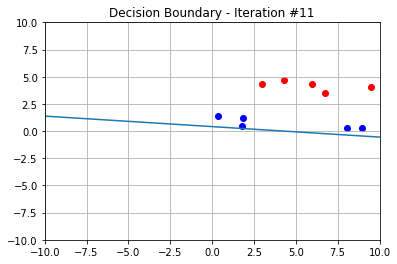

iteration #12
m = 0.499107
b = 0.598843



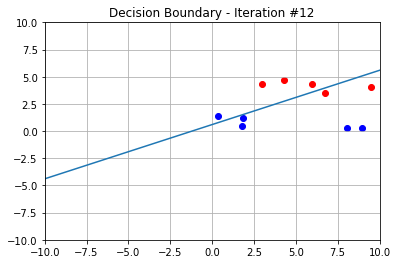

iteration #13
m = 0.035285
b = 0.484289



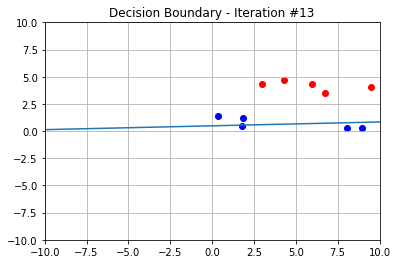

iteration #14
m = 0.095969
b = 0.569992



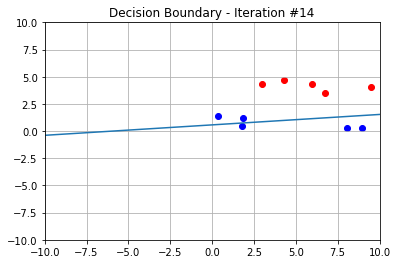

iteration #15
m = 0.164729
b = 0.667657



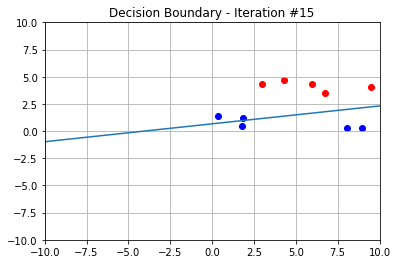

iteration #16
m = 0.244250
b = 0.780624



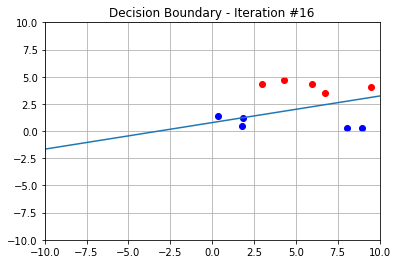

iteration #17
m = 0.290137
b = 0.868421



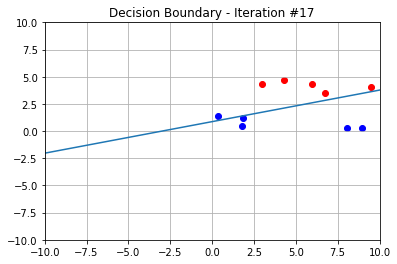

iteration #18
m = 0.316559
b = 0.942663



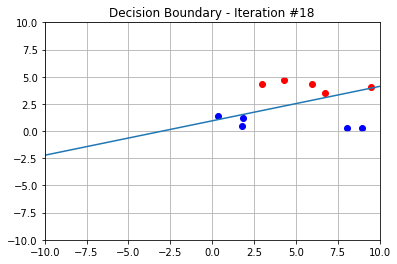

iteration #19
m = 0.323828
b = 1.013714



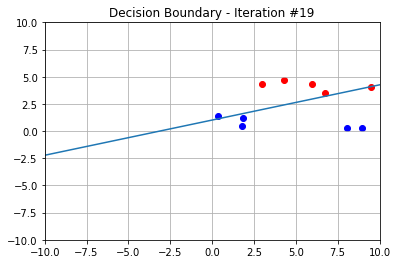

iteration #20
m = 0.096599
b = 0.972937



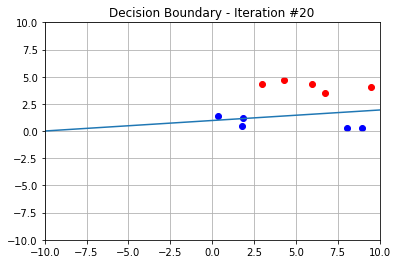

iteration #21
m = 0.171765
b = 1.121098



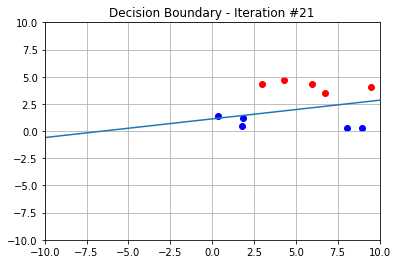

iteration #22
m = 0.195123
b = 1.217558



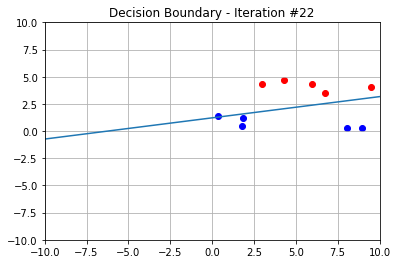

iteration #23
m = 0.218534
b = 1.314878



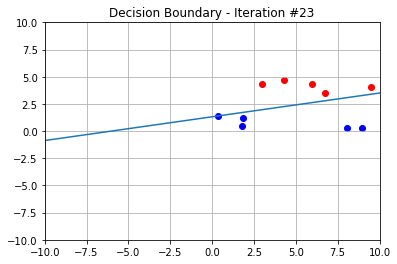

iteration #24
m = 0.230981
b = 1.366638



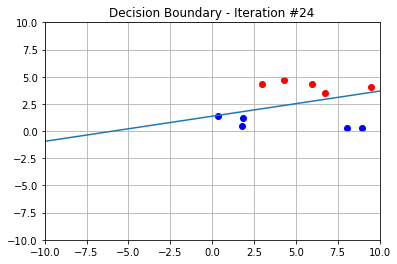

iteration #25
m = 0.236454
b = 1.389430



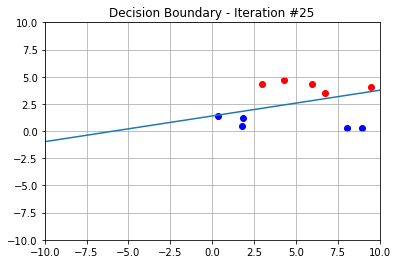

iteration #26
m = 0.239973
b = 1.404260



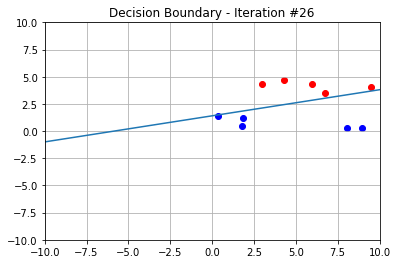

iteration #27
m = 0.242484
b = 1.415289



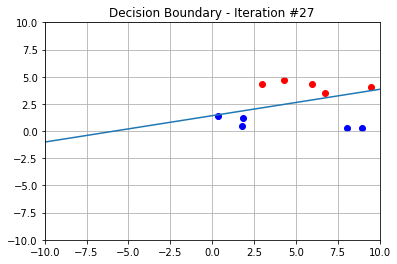

iteration #28
m = 0.244275
b = 1.424013



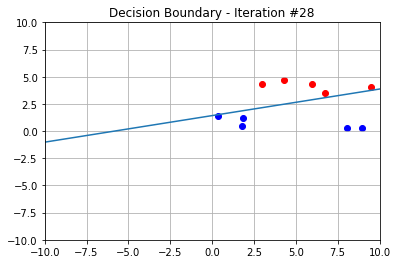

iteration #29
m = 0.245443
b = 1.431138



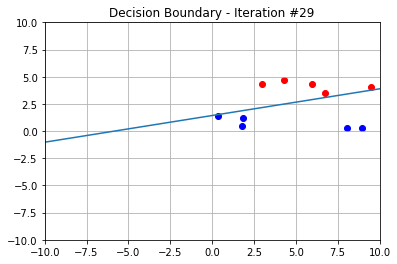

iteration #30
m = 0.246049
b = 1.437071



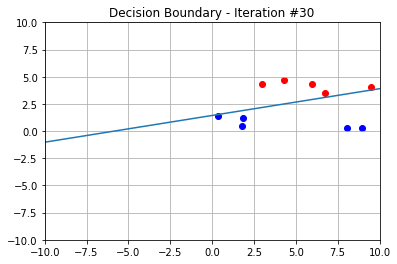

iteration #31
m = 0.246190
b = 1.442105



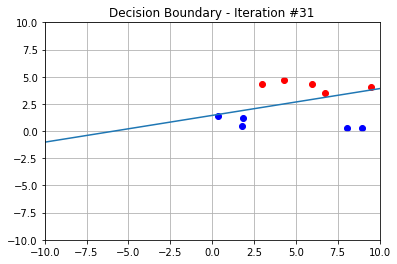

iteration #32
m = 0.245998
b = 1.446479



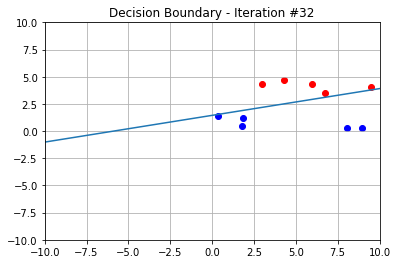

iteration #33
m = 0.245603
b = 1.450378



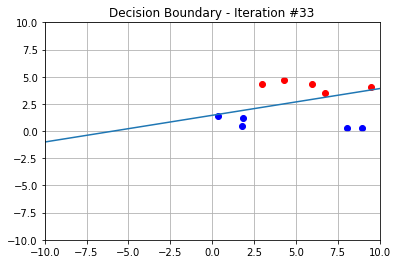

iteration #34
m = 0.245102
b = 1.453930



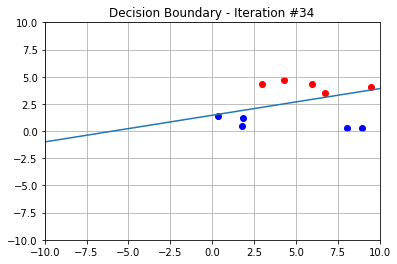

iteration #35
m = 0.244553
b = 1.457218



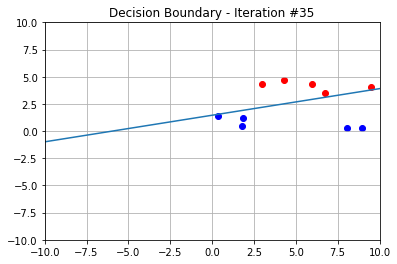

iteration #36
m = 0.243989
b = 1.460298



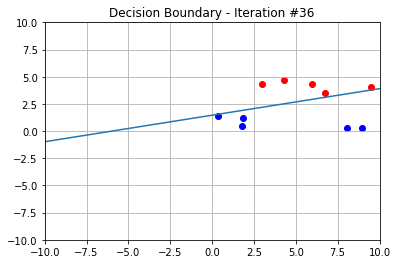

iteration #37
m = 0.243428
b = 1.463203



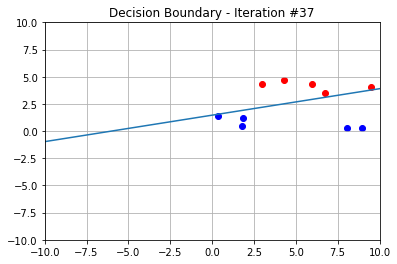

iteration #38
m = 0.242878
b = 1.465959



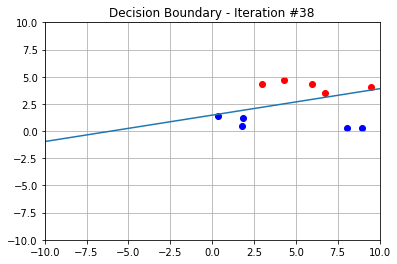

iteration #39
m = 0.242344
b = 1.468584



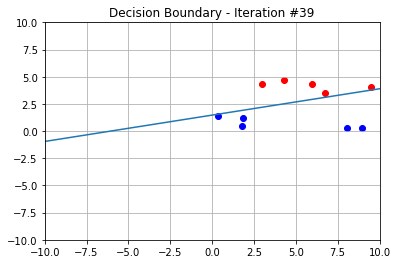

iteration #40
m = 0.241827
b = 1.471091



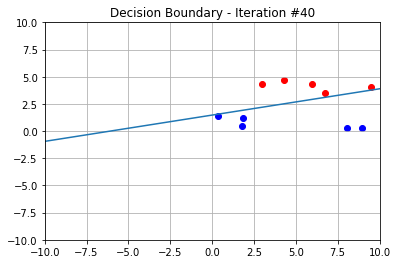

iteration #41
m = 0.241327
b = 1.473493



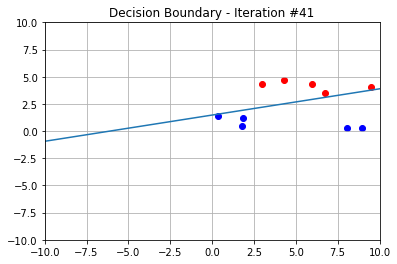

iteration #42
m = 0.240844
b = 1.475798



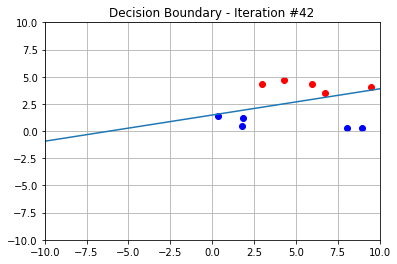

iteration #43
m = 0.240377
b = 1.478016



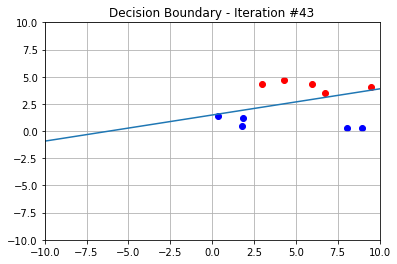

iteration #44
m = 0.239926
b = 1.480151



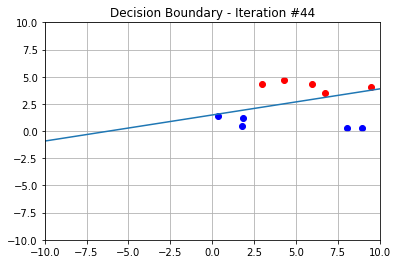

iteration #45
m = 0.239490
b = 1.482212



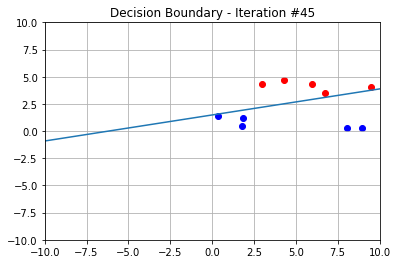

iteration #46
m = 0.239067
b = 1.484202



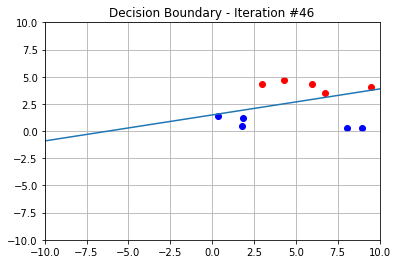

iteration #47
m = 0.238657
b = 1.486127



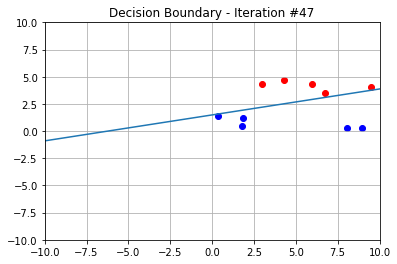

iteration #48
m = 0.238260
b = 1.487992



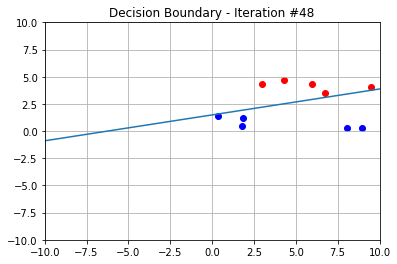

iteration #49
m = 0.237874
b = 1.489799



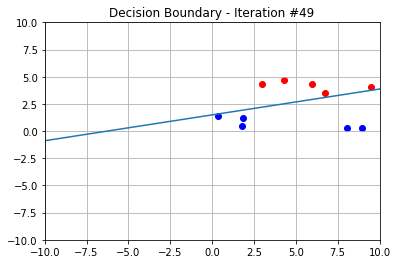

iteration #50
m = 0.237500
b = 1.491553



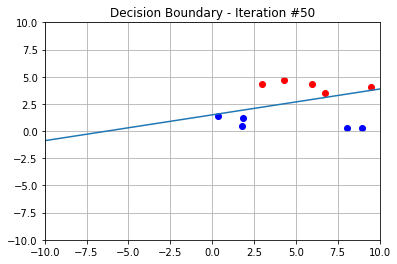

iteration #51
m = 0.237135
b = 1.493256



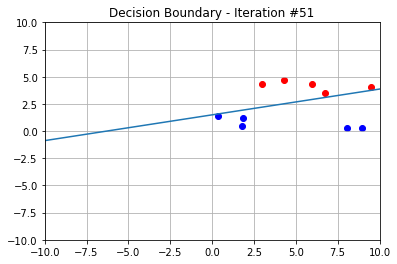

iteration #52
m = 0.236780
b = 1.494912



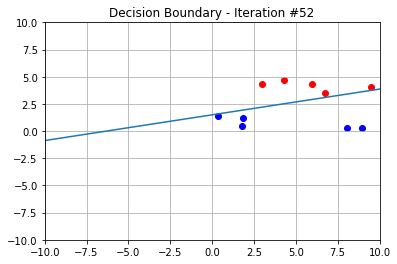

iteration #53
m = 0.236435
b = 1.496522



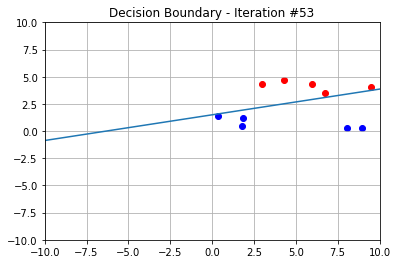

iteration #54
m = 0.236098
b = 1.498091



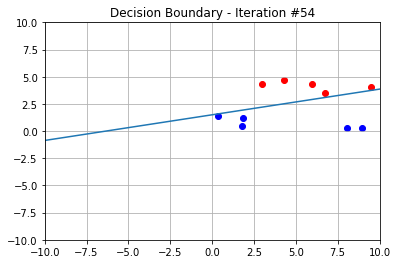

iteration #55
m = 0.235770
b = 1.499619



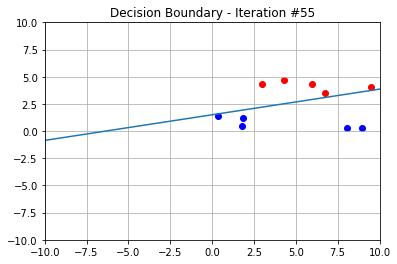

iteration #56
m = 0.235450
b = 1.501109



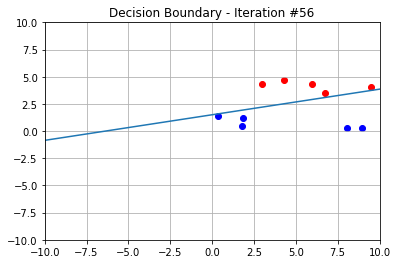

iteration #57
m = 0.235137
b = 1.502563



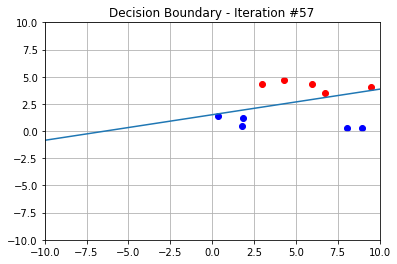

iteration #58
m = 0.234831
b = 1.503982



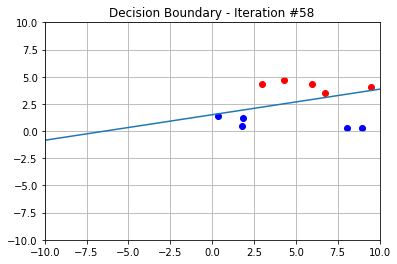

iteration #59
m = 0.234532
b = 1.505368



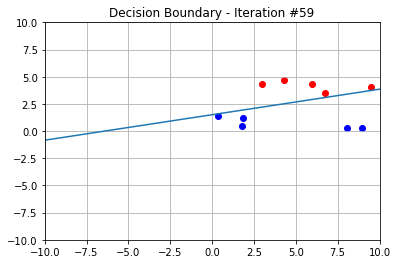

iteration #60
m = 0.234239
b = 1.506723



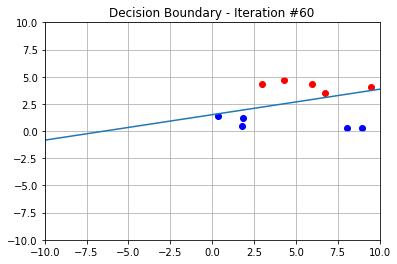

iteration #61
m = 0.233953
b = 1.508048



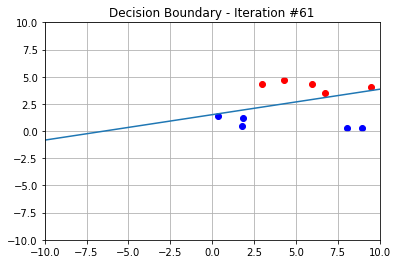

iteration #62
m = 0.233673
b = 1.509345



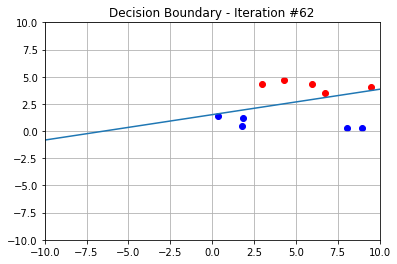

iteration #63
m = 0.233398
b = 1.510614



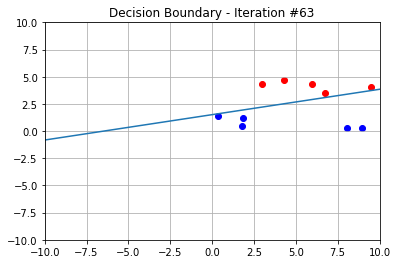

iteration #64
m = 0.233129
b = 1.511857



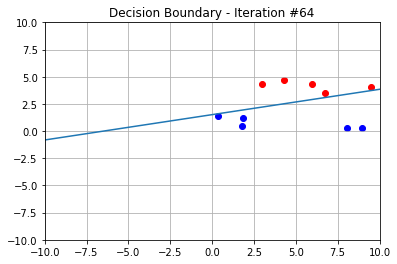

iteration #65
m = 0.232866
b = 1.513074



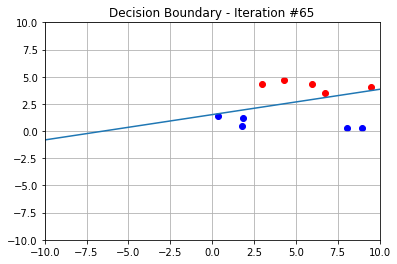

iteration #66
m = 0.232607
b = 1.514268



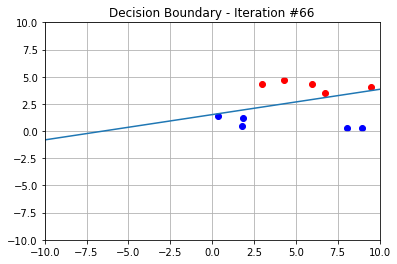

iteration #67
m = 0.232353
b = 1.515439



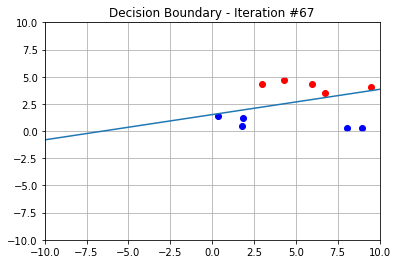

iteration #68
m = 0.232103
b = 1.516587



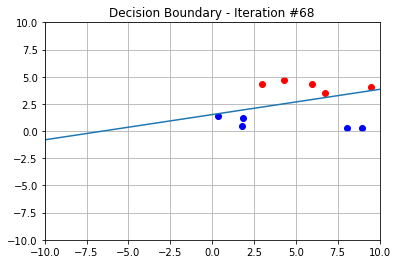

iteration #69
m = 0.231859
b = 1.517714



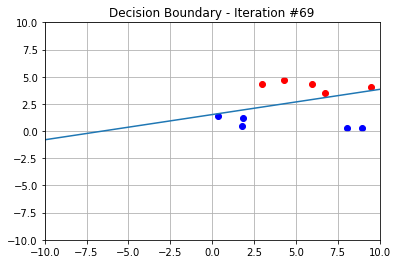

iteration #70
m = 0.231618
b = 1.518820



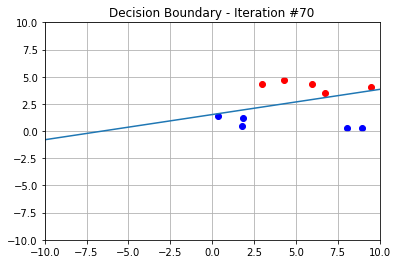

iteration #71
m = 0.231382
b = 1.519906



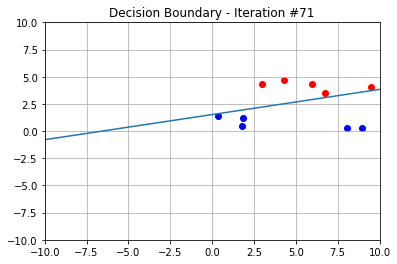

iteration #72
m = 0.231149
b = 1.520974



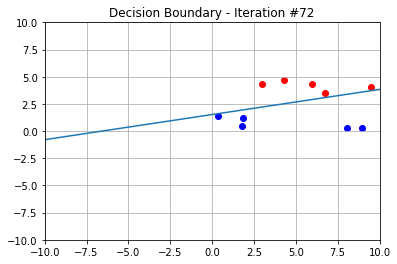

iteration #73
m = 0.230921
b = 1.522022



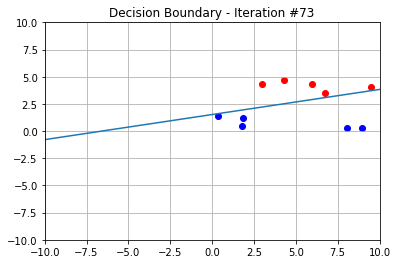

iteration #74
m = 0.230696
b = 1.523053



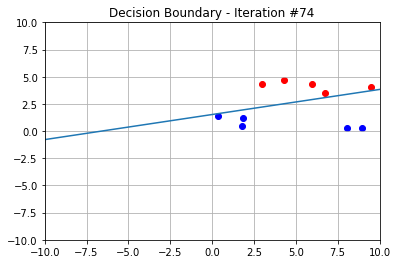

iteration #75
m = 0.230475
b = 1.524067



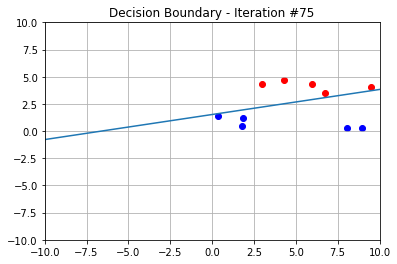

iteration #76
m = 0.230257
b = 1.525064



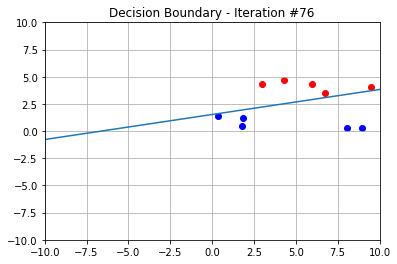

iteration #77
m = 0.230043
b = 1.526045



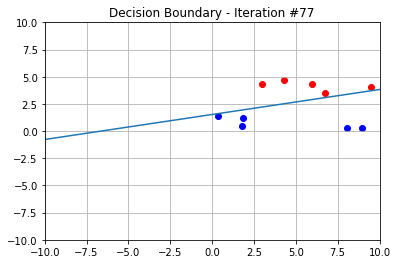

iteration #78
m = 0.229832
b = 1.527011



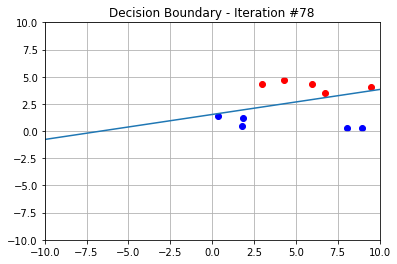

iteration #79
m = 0.229624
b = 1.527961



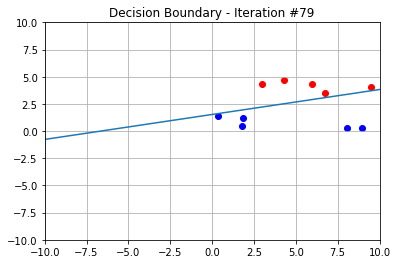

iteration #80
m = 0.229419
b = 1.528897



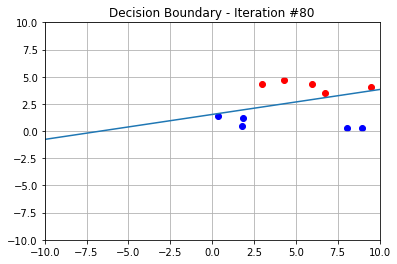

iteration #81
m = 0.229218
b = 1.529819



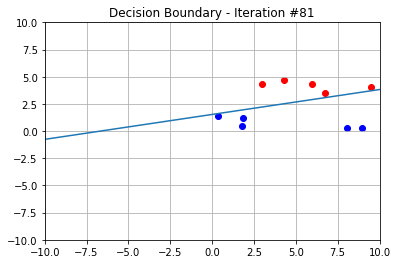

iteration #82
m = 0.229019
b = 1.530727



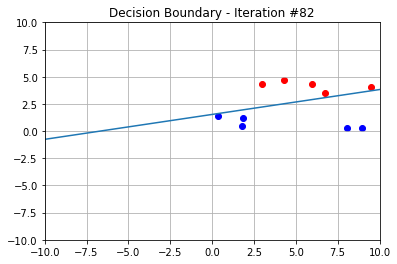

iteration #83
m = 0.228823
b = 1.531621



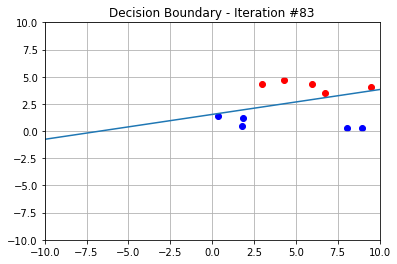

iteration #84
m = 0.228629
b = 1.532503



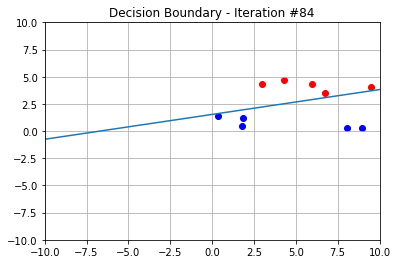

iteration #85
m = 0.228438
b = 1.533373



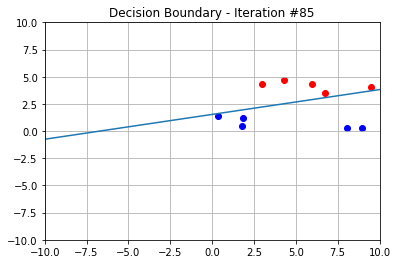

iteration #86
m = 0.228250
b = 1.534230



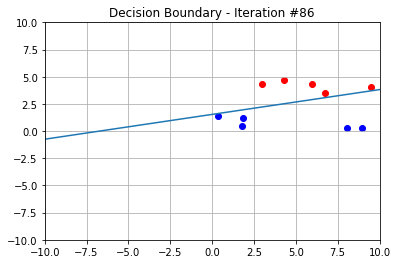

iteration #87
m = 0.228065
b = 1.535075



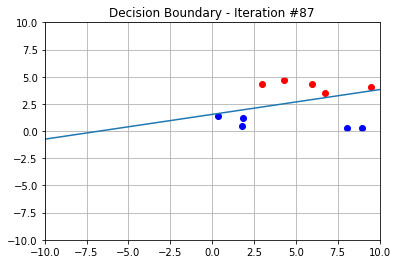

iteration #88
m = 0.227881
b = 1.535909



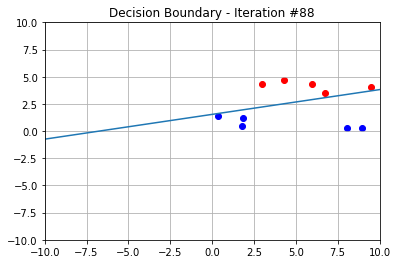

iteration #89
m = 0.227700
b = 1.536731



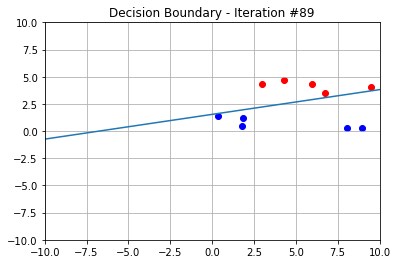

iteration #90
m = 0.227522
b = 1.537543



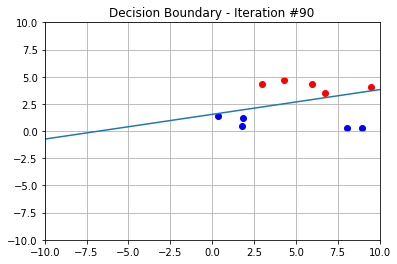

iteration #91
m = 0.227345
b = 1.538344



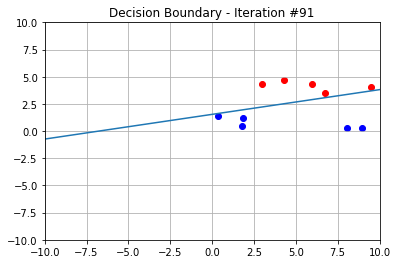

iteration #92
m = 0.227171
b = 1.539135



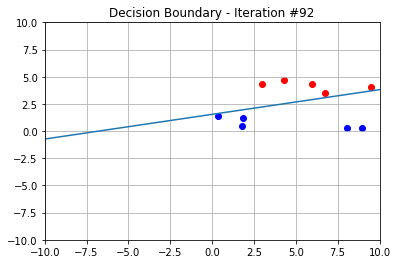

iteration #93
m = 0.226999
b = 1.539916



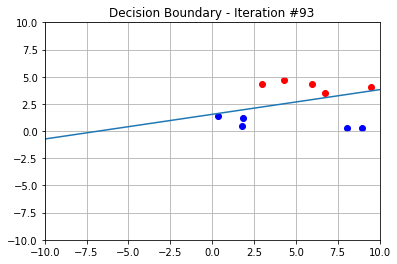

iteration #94
m = 0.226829
b = 1.540687



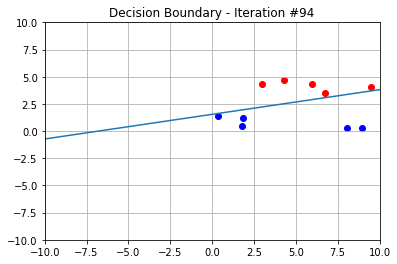

In [19]:
# scratch pad for testing and experimentation
!python3 --version

#test_Accu_eval()
#test_calculate_fold_sizes()
#test_K_Fold_Cross_Validation()
#test_sigmoid()
#test_predict()
#test_cross_entropy_loss()
test_fit()